In [1]:
from sklearn.linear_model import LogisticRegression
import torch
import pickle
import torch.nn as nn
from tqdm import tqdm
from utils import float32_to_int16, int16_to_float32
from einops import rearrange #might need to do pip install einops
import warnings
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# read in pickle data
with open('activations/activations.pkl', 'rb') as f:
    all_xs = pickle.load(f) # shape: (batch_size, num_layers, k, model_dim)

# shuffle all_xs
all_xs = all_xs[torch.randperm(all_xs.size()[0])]
train_split = int(.8 * len(all_xs))
x_train = all_xs[:train_split]
x_test = all_xs[train_split:]

In [3]:
class Probe(nn.Module):
    def __init__(self):
        super().__init__()
        self.probe = nn.Linear(768,1, bias=True).to(torch.float32)
    def forward(self, x):
        return torch.sigmoid(self.probe(x))
    def complement(self):
        p = Probe()
        p.probe.weight.data = -self.probe.weight.data
        p.probe.bias.data = -self.probe.bias.data
        return p

def gabe_loss(data, probe):
    probs = probe(data).squeeze(dim=-1)
    probs = probs.sort(dim=-1, descending=True).values
    l_big = (1 - probs[:,0])**2
    l_small = (probs[:,1:]**2).sum(dim=-1)
    return (l_big + l_small).mean()

def probe_acc(data, probe):
    probs = probe.probe(data).squeeze(dim=-1)   # Note that we *don't* apply the sigmoid here for rounding reasons.
    correct = (probs.max(dim=-1).indices == 0).sum().item()
    return correct/len(data)


def cross_entropy_loss(data, probe):
    probs = probe(data).squeeze(dim=-1)
    l_fst = -probs[:,0].log()
    l_snd = -(1 - probs[:,1:]).log().sum(dim=-1)
    return (l_fst + l_snd).mean()


def ccs_loss(pair, probe):
    assert pair.shape[-2] == 2
    probs = probe(pair).squeeze(dim=-1)
    l_const = (1 - probs.sum(dim=-1))**2
    l_conf = (probs.min(dim=-1).values)**2
    return (l_const + l_conf).mean()

In [23]:
with open("probes/lr_probes.pkl", "rb") as f:
    lr_probes = pickle.load(f)
with open("probes/gabe_probes.pkl", "rb") as f:
    gabe_probes = pickle.load(f)
with open("probes/ccs_probes.pkl", "rb") as f:
    ccs_probes = pickle.load(f)
with open("probes/lots_of_probes.pkl", "rb") as f:
    lots_of_probes = pickle.load(f)

In [77]:
#train our own LR probes
lr_probes = {}

num_attempts = 2
epochs = 50000

lr_train_loss_history = {}
lr_test_loss_history = {}
lr_train_acc_history = {}
lr_test_acc_history = {}

num_classes = 4
for layer in tqdm(range(1,13)):
    for attempt in range(num_attempts):
            p = Probe().to(DEVICE)
            p.probe.weight.data = torch.randn((1, 768), device=DEVICE, dtype=torch.float32)/1000    #initialize to small values, otherwise loss is NaN
            optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
            for i in range(epochs):
                optimizer.zero_grad()
                loss = cross_entropy_loss(x_train[:, layer-1, :num_classes], p)
                loss.backward()
                optimizer.step()
                if i % 100 == 0:
                    lr_train_loss_history[(num_classes, layer, attempt, i)] = cross_entropy_loss(x_train[:, layer-1, :num_classes], p).item()
                    lr_test_loss_history[(num_classes, layer, attempt, i)] = cross_entropy_loss(x_test[:, layer-1, :num_classes], p).item()
                    lr_train_acc_history[(num_classes, layer, attempt, i)] = probe_acc(x_train[:, layer-1, :num_classes], p)
                    lr_test_acc_history[(num_classes, layer, attempt, i)] = probe_acc(x_test[:, layer-1, :num_classes], p)

                if i == epochs-1:
                        print(f"layer{layer} epoch{i}, loss = {loss.item()}, acc = {probe_acc(x_test[:, layer-1, :num_classes], p)}")
            lr_probes[(num_classes, layer, attempt)] = p


  0%|          | 0/12 [00:00<?, ?it/s]

layer1 epoch49999, loss = 2.2386131286621094, acc = 0.24


  8%|▊         | 1/12 [02:19<25:36, 139.68s/it]

layer1 epoch49999, loss = 2.238619565963745, acc = 0.24
layer2 epoch49999, loss = 2.227883815765381, acc = 0.235


 17%|█▋        | 2/12 [04:38<23:13, 139.37s/it]

layer2 epoch49999, loss = 2.2278850078582764, acc = 0.235
layer3 epoch49999, loss = 2.2227189540863037, acc = 0.23


 25%|██▌       | 3/12 [06:58<20:53, 139.32s/it]

layer3 epoch49999, loss = 2.2227237224578857, acc = 0.23
layer4 epoch49999, loss = 2.2100441455841064, acc = 0.305


 33%|███▎      | 4/12 [09:18<18:36, 139.61s/it]

layer4 epoch49999, loss = 2.210040807723999, acc = 0.305
layer5 epoch49999, loss = 2.2085111141204834, acc = 0.3325


 42%|████▏     | 5/12 [11:38<16:18, 139.77s/it]

layer5 epoch49999, loss = 2.2088124752044678, acc = 0.33
layer6 epoch49999, loss = 2.1981256008148193, acc = 0.3175


 50%|█████     | 6/12 [13:57<13:58, 139.72s/it]

layer6 epoch49999, loss = 2.1981284618377686, acc = 0.3175
layer7 epoch49999, loss = 2.1861836910247803, acc = 0.355


 58%|█████▊    | 7/12 [16:17<11:38, 139.79s/it]

layer7 epoch49999, loss = 2.1861934661865234, acc = 0.3525
layer8 epoch49999, loss = 2.1701056957244873, acc = 0.35


 67%|██████▋   | 8/12 [18:37<09:19, 139.88s/it]

layer8 epoch49999, loss = 2.1701059341430664, acc = 0.3475
layer9 epoch49999, loss = 2.1552765369415283, acc = 0.37


 75%|███████▌  | 9/12 [20:57<06:59, 139.69s/it]

layer9 epoch49999, loss = 2.1546459197998047, acc = 0.37
layer10 epoch49999, loss = 2.110130548477173, acc = 0.3625


 83%|████████▎ | 10/12 [23:17<04:39, 139.83s/it]

layer10 epoch49999, loss = 2.1098296642303467, acc = 0.365
layer11 epoch49999, loss = 2.0828776359558105, acc = 0.4025


 92%|█████████▏| 11/12 [25:36<02:19, 139.57s/it]

layer11 epoch49999, loss = 2.082890510559082, acc = 0.4025
layer12 epoch49999, loss = 2.1114375591278076, acc = 0.4275


100%|██████████| 12/12 [27:55<00:00, 139.64s/it]

layer12 epoch49999, loss = 2.111515998840332, acc = 0.4275


In [ ]:
# plot both losses and accuracies on same graph
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot([lr_train_loss_history[(4,1,0,i)] for i in range(0,epochs,100)], label=f'train loss')
plt.plot([lr_test_loss_history[(4,1,0,i)] for i in range(0,epochs,100)], label=f'test loss')
plt.plot([lr_train_loss_history[(4,1,1,i)] for i in range(0,epochs,100)], label=f'train loss')
plt.plot([lr_test_loss_history[(4,1,1,i)] for i in range(0,epochs,100)], label=f'test loss')
plt.title("Probe loss over time (k=4)")
plt.legend()

plt.subplot(2,1,2)
plt.plot([lr_train_acc_history[(4,1,0,i)] for i in range(0,epochs,100)], label=f'train acc')
plt.plot([lr_test_acc_history[(4,1,0,i)] for i in range(0,epochs,100)], label=f'test acc')
plt.plot([lr_train_acc_history[(4,1,1,i)] for i in range(0,epochs,100)], label=f'train acc')
plt.plot([lr_test_acc_history[(4,1,1,i)] for i in range(0,epochs,100)], label=f'test acc')
plt.title("Probe accuracy over time (k=4)")
plt.legend()
plt.show()


In [ ]:

epochs = 50000
num_attempts = 5

gabe_probes = {}
gabe_losses = {}
gabe_loss_history = {}

train_loss_history = {}
test_loss_history = {}
train_acc_history = {}
test_acc_history = {}

for num_classes in [4, 3, 2]:
    print(f"starting k = {num_classes}")
    for layer in range(12, 0, -1): #
        print(f"starting layer {layer}")

        for attempt in range(num_attempts):
            p = Probe().to(DEVICE)
            optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
            for i in range(epochs):
                optimizer.zero_grad()
                loss = gabe_loss(x_train[:, layer-1, :num_classes], p)
                loss.backward()
                optimizer.step()
                if i % 100 == 0:
                    train_loss_history[(num_classes, layer, attempt, i)] = gabe_loss(x_train[:, layer-1, :num_classes], p).item()
                    test_loss_history[(num_classes, layer, attempt, i)] = gabe_loss(x_test[:, layer-1, :num_classes], p).item()
                    train_acc_history[(num_classes, layer, attempt, i)] = probe_acc(x_train[:, layer-1, :num_classes], p)
                    test_acc_history[(num_classes, layer, attempt, i)] = probe_acc(x_test[:, layer-1, :num_classes], p)
                    # if i == epochs-100 and attempt == num_attempts-1:
                    #     print(f'layer {layer} attempt {attempt} epoch {i} train_loss {train_loss_history[(layer, attempt, i)]} test_loss {test_loss_history[(layer, attempt, i)]} train_acc {train_acc_history[(layer, attempt, i)]} test_acc {test_acc_history[(layer, attempt, i)]}')
            
            gabe_probes[(num_classes, layer, attempt)] = p
        
        print(f"finished layer {layer}, representative test_acc={test_acc_history[(num_classes, layer, 0, epochs-100)]}")
    
    with open(f'probes/gabe_probes_v2.pkl', 'wb') as f:
        pickle.dump(gabe_probes, f)
        

In [25]:
# get best probe by worst train loss
gabe_probe_indices = {}
num_attempts = 5
for num_classes in [4, 3, 2]:
    for layer in range(1,13):
        # gabe_probe_indices[(num_classes, layer)] = np.argmax([gabe_loss(x_train[:,layer-1,:num_classes], gabe_probes[(num_classes, layer, att)]).item() for att in range(num_attempts)])
        gabe_probe_indices[(num_classes, layer)] = np.argmax([probe_acc(x_train[:,layer-1,:num_classes], gabe_probes[(num_classes, layer, att)]) for att in range(num_attempts)])

In [28]:
# Train CCS probes
epochs = 50000
num_attempts = 5

ccs_probes = {}

ccs_train_loss_history = {}
ccs_test_loss_history = {}
ccs_train_acc_history = {}
ccs_test_acc_history = {}


num_classes = 2
for layer in range(12, 0, -1): #
    print(f"starting layer {layer}")

    for attempt in range(num_attempts):
        p = Probe().to(DEVICE)
        optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
        for i in range(epochs):
            optimizer.zero_grad()
            loss = ccs_loss(x_train[:, layer-1, :num_classes], p)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                ccs_train_loss_history[(num_classes, layer, attempt, i)] = gabe_loss(x_train[:, layer-1, :num_classes], p).item()
                ccs_test_loss_history[(num_classes, layer, attempt, i)] = gabe_loss(x_test[:, layer-1, :num_classes], p).item()
                ccs_train_acc_history[(num_classes, layer, attempt, i)] = probe_acc(x_train[:, layer-1, :num_classes], p)
                ccs_test_acc_history[(num_classes, layer, attempt, i)] = probe_acc(x_test[:, layer-1, :num_classes], p)
            if i == epochs-1:
                print(f'layer {layer} attempt {attempt} epoch {i} train_loss {loss} test_acc {probe_acc(x_test[:, layer-1, :num_classes], p)}')
        
        ccs_probes[(layer, attempt)] = p
    
    print(f"finished layer {layer}")
    
    with open(f'probes/ccs_probes.pkl', 'wb') as f:
        pickle.dump(ccs_probes, f)
        

starting layer 12
layer 12 attempt 0 epoch 49999 train_loss 0.15238849818706512 test_acc 0.465
layer 12 attempt 1 epoch 49999 train_loss 0.15224017202854156 test_acc 0.46
layer 12 attempt 2 epoch 49999 train_loss 0.15231524407863617 test_acc 0.4675
layer 12 attempt 3 epoch 49999 train_loss 0.15236009657382965 test_acc 0.465
layer 12 attempt 4 epoch 49999 train_loss 0.1621881127357483 test_acc 0.5675
finished layer 12
starting layer 11
layer 11 attempt 0 epoch 49999 train_loss 0.2553772032260895 test_acc 0.5075
layer 11 attempt 1 epoch 49999 train_loss 0.21633441746234894 test_acc 0.5575
layer 11 attempt 2 epoch 49999 train_loss 0.26223984360694885 test_acc 0.5225
layer 11 attempt 3 epoch 49999 train_loss 0.2897091507911682 test_acc 0.5775
layer 11 attempt 4 epoch 49999 train_loss 0.2740677297115326 test_acc 0.53
finished layer 11
starting layer 10
layer 10 attempt 0 epoch 49999 train_loss 0.23584894835948944 test_acc 0.4975
layer 10 attempt 1 epoch 49999 train_loss 0.3111422657966614 t

In [24]:
# Flip CCS probes and k=2 probes
for layer in range(1,13):
    for att in range(num_attempts):
        if probe_acc(x_train[:,layer-1,:2], ccs_probes[(layer, att)]) < 0.5:
            ccs_probes[(layer, att)] = ccs_probes[(layer, att)].complement()
        if probe_acc(x_train[:,layer-1,:2], gabe_probes[(2, layer, att)]) < 0.5:
            gabe_probes[(2, layer, att)] = gabe_probes[(2, layer, att)].complement()

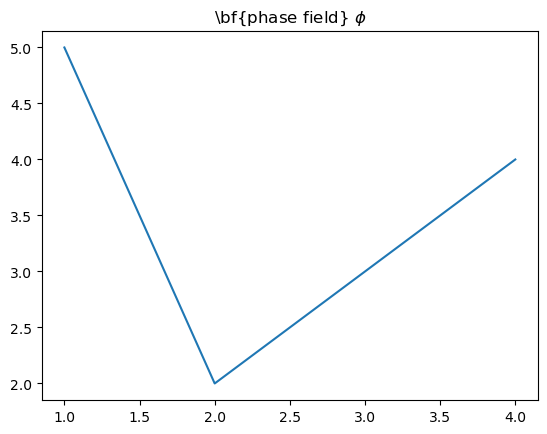

In [37]:
# plt.rcParams['text.usetex'] = False
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.plot([1,2,4],[5,2,4])
plt.title(r"\bf{phase field} $\phi$")
plt.show()

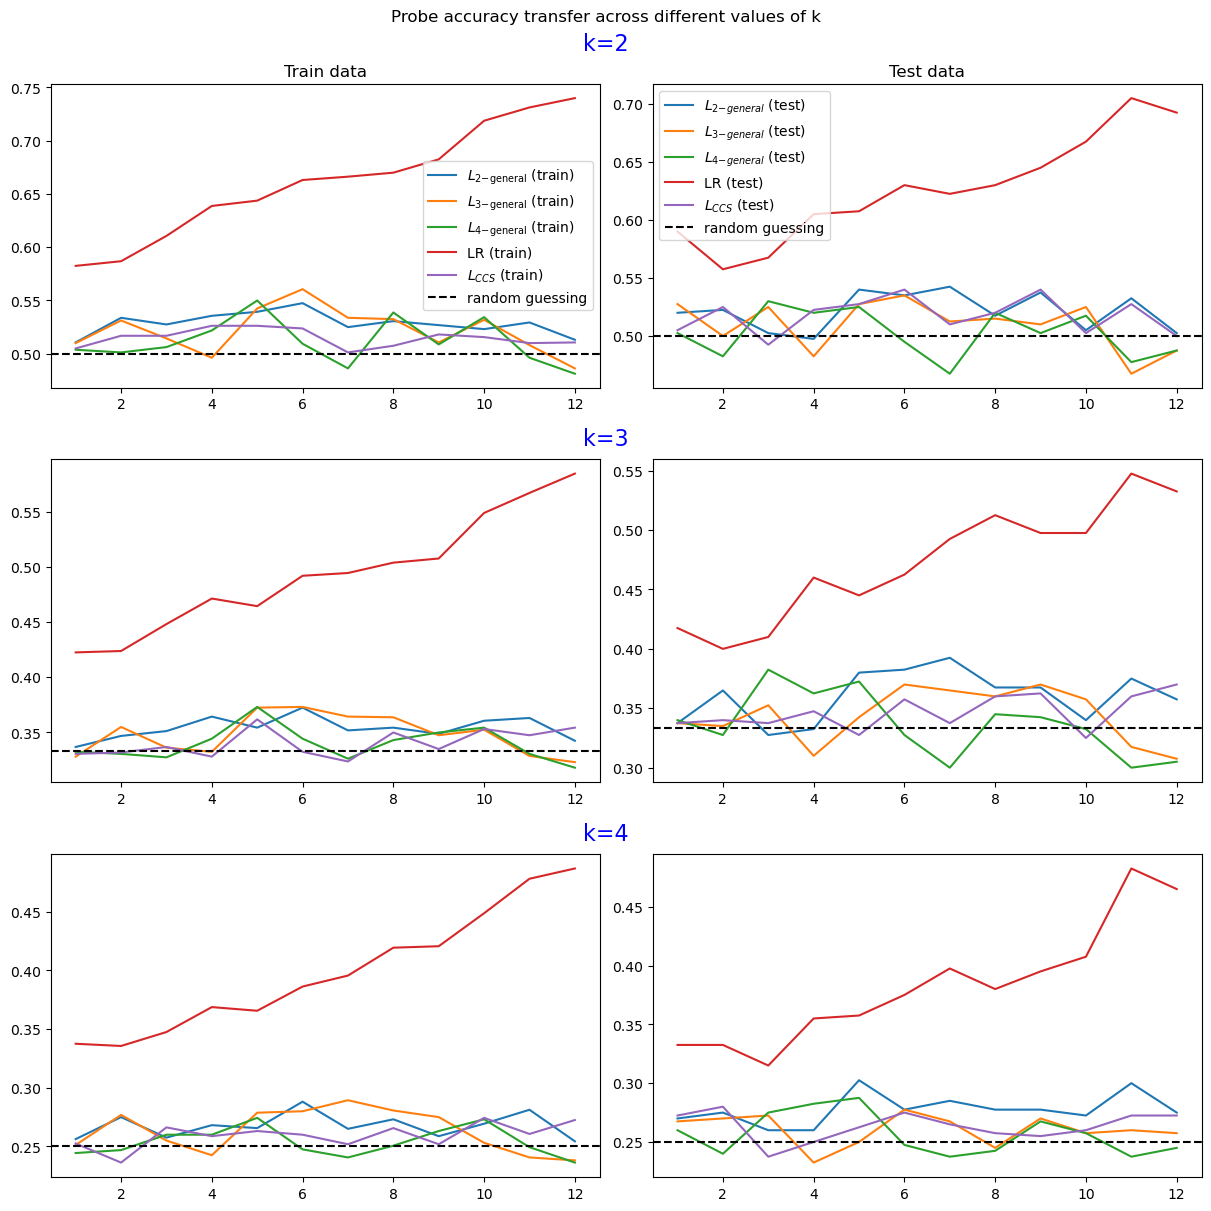

<Figure size 1200x1200 with 0 Axes>

In [41]:
# plot gabe_acc per layer
num_classes = 2

def get_gabe_accs(dataset, dataset_k, probe_k):
    return [probe_acc(dataset[:,i-1,:dataset_k], gabe_probes[(probe_k, i, gabe_probe_indices[(probe_k, i)])]) for i in range(1,13)]

def get_gabe_accs_avg(dataset, dataset_k, probe_k):
    return [sum([probe_acc(dataset[:,i-1,:dataset_k], gabe_probes[(probe_k, i, j)]) for j in range(num_attempts)])/num_attempts
            for i in range(1,13)]

# gabe_train_accs = [probe_acc(x_train[:,i-1,:num_classes], gabe_probes[(num_classes, i, gabe_probe_indices[(num_classes, i)])]) for i in range(1,13)]
# gabe_test_accs = [probe_acc(x_test[:,i-1,:num_classes], gabe_probes[(num_classes, i, gabe_probe_indices[(num_classes, i)])]) for i in range(1,13)]
def get_ccs_accs(dataset, dataset_k):
    return [probe_acc(dataset[:,i-1,:dataset_k], ccs_probes[(i, 0)]) for i in range(1,13)]

def get_lr_accs(dataset, dataset_k):
    return [probe_acc(dataset[:,i-1,:dataset_k], lr_probes[(4,i,0)]) for i in range(1,13)]  # use the first probe for lr

# lr_train_accs = [probe_acc(x_train[:,i-1,:num_classes], lr_probes[(4,i,1)]) for i in range(1,13)]
# lr_test_accs = [probe_acc(x_test[:,i-1,:num_classes], lr_probes[(4,i,1)]) for i in range(1,13)]

indices = np.arange(1,13)

fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle(f"Probe accuracy transfer across different values of k")
subfigs = fig.subfigures(3, 1)


plt.figure(figsize=(12,12))

for i,k in enumerate([2,3,4]):
    
    subfigs[i].suptitle(f"k={k}", color="blue", fontsize=16)
    ax = subfigs[i].subplots(1, 2)
    for probe_k in [2,3,4]:
        ax[0].plot(indices, get_gabe_accs(x_train, k, probe_k), label=f'$L_{{{probe_k}\\mathrm{{-gen}}}}$ (train)')
        ax[1].plot(indices, get_gabe_accs(x_test, k, probe_k), label=f'$L_{{{probe_k}\\mathrm{{-general}}}}$ (test)')
    ax[0].plot(indices, get_lr_accs(x_train, k), label=f'LR (train)')
    ax[1].plot(indices, get_lr_accs(x_test, k), label=f'LR (test)')
    
    ax[0].plot(indices, get_ccs_accs(x_train, k), label=f'$L_{{{{CCS}}}}$ (train)')
    ax[1].plot(indices, get_ccs_accs(x_test, k), label=f'$L_{{{{CCS}}}}$ (test)')

    # ax[0].set_ylim(0,1)
    # ax[1].set_ylim(0,1)

    #make dashed horizontal line at y = 1/k
    for j in range(2):
        ax[j].axhline(1/k, color='black', linestyle='--', label=f'random guessing')

    if i == 0:
        ax[0].set_title("Train data")
        ax[1].set_title("Test data")
        ax[0].legend()
        ax[1].legend()
plt.show()


In [ ]:
display_layer = 10

fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle(f"Probe output on correct vs incorrect completion in Layer {display_layer}.")

subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle("Linear Regression", color="green")
ax = subfigs[0].subplots(1, 2)
ax[0].scatter(lr_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            lr_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[0].set_title("Train data")
ax[0].set_xlabel("Prob. assigned to correct completion")
ax[0].set_ylabel("Prob. assigned to incorrect completion")

ax[1].scatter(lr_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            lr_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[1].set_title("Test data")

#add line y=x
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color="red")
ax[1].plot(x, x, color="red")


#Do the same for Gabe
subfigs[1].suptitle("Gabe", color="green")
ax = subfigs[1].subplots(1, 2)
ax[0].scatter(gabe_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            gabe_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[1].scatter(gabe_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            gabe_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu())

#add line y=x
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color="red")
ax[1].plot(x, x, color="red")

plt.show()

In [128]:
# lots_of_probes = []
num_attempts = 50 - len(lots_of_probes)
layer = 6
num_classes = 2

epochs = 50000
layer = 4

for attempt in tqdm(range(num_attempts)):
    p = Probe().to(DEVICE)
    optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
    for i in range(epochs):
        optimizer.zero_grad()
        loss = ccs_loss(x_train[:, layer-1, :num_classes], p)
        loss.backward()
        optimizer.step()
    lots_of_probes.append(p)

    with open("probes/lots_of_probes_ccs.pkl", "wb") as f:
        pickle.dump(lots_of_probes, f)

  8%|▊         | 3/40 [03:22<41:41, 67.61s/it]

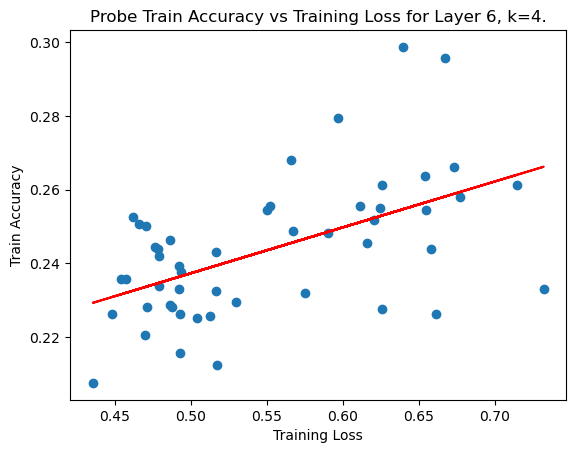

In [20]:
# plot probe final test accuracy vs training loss
layer = 6
num_classes = 4

def flip(x):
    return max(x, 1-x)

num_attempts = 5

# train_loss = [ccs_loss(x_train[:, layer-1, :num_classes], p).item() for p in lots_of_probes_ccs]
# test_accs = [probe_acc(x_test[:, layer-1, :num_classes], p) for p in lots_of_probes_ccs]
# train_accs = [flip(probe_acc(x_train[:, layer-1, :num_classes], p)) for p in lots_of_probes_ccs]

train_loss = [gabe_loss(x_train[:, layer-1, :num_classes], p).item() for p in lots_of_probes]
test_accs = [probe_acc(x_test[:, layer-1, :num_classes], p) for p in lots_of_probes]
train_accs = [probe_acc(x_train[:, layer-1, :num_classes], p) for p in lots_of_probes]

# train_loss = [gabe_loss(x_train[:, layer-1, :num_classes], gabe_probes[(num_classes, layer, i)]).item() for i in range(num_attempts)]
# test_accs = [probe_acc(x_test[:, layer-1, :num_classes], gabe_probes[(num_classes, layer, i)]) for i in range(num_attempts)]
# train_accs = [(probe_acc(x_train[:, layer-1, :num_classes], gabe_probes[(num_classes, layer, i)])) for i in range(num_attempts)]

# train_loss = [ccs_loss(x_train[:, layer-1, :num_classes], p).item() for p in lots_of_probes]
# test_accs = [(lambda x: max(x, 1-x))(probe_acc(x_test[:, layer-1, :num_classes], p)) for p in lots_of_probes]

# include trend line
z = np.polyfit(train_loss, train_accs, 1)
p = np.poly1d(z)
plt.plot(train_loss, p(train_loss), "r")

plt.scatter(train_loss, train_accs)
plt.xlabel("Training Loss")
plt.ylabel("Train Accuracy")
plt.title(f"Probe Train Accuracy vs Training Loss for Layer {layer}, k={num_classes}.")
plt.show()
    

In [19]:
# plot accuracy history of probe
for layer in range(1, 13):
    for att in range(5):
        plt.plot([history["test_acc_history"][(2, layer, att, i)] for i in range(0, epochs, 100)])
plt.show()

NameError: name 'epochs' is not defined

In [87]:
with open("probes/lots_of_probes.pkl", "rb") as f:
    lots_of_probes = pickle.load(f)
with open("probes/lots_of_probes_ccs.pkl", "rb") as f:
    lots_of_probes_ccs = pickle.load(f)